## Explore Light curve

Here we look at some individual light curves. The data has been created by running the [Build-Reference-PSC](PIAA-Build-Reference-PSC.ipynb) script (typically from the command line script `$PIAA/scripts/PIAA-Build-Reference-PSC-Parallel.py`).

In [1]:
import os
import numpy as np
import pandas as pd

from glob import glob

from matplotlib import pyplot as plt
plt.style.use('bmh')
from IPython import display

from tqdm import tqdm_notebook

from astropy.time import Time
from astropy.stats import sigma_clip

# from piaa.utils.exoplanets import TransitInfo, get_exoplanet_transit
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils import pipeline

In [2]:
processed_dir = os.path.join(os.environ['PANDIR'], 'processed')
fields_dir = os.path.join(os.environ['PANDIR'], 'images', 'fields')

In [3]:
# unit_id = 'PAN001'
# field_id = 'Tess_Sec05_Cam01'
# cam_id = '14d3bd'
# seq_id = '20181226T051416'

unit_id = 'PAN012'
field_id = 'Hd189733'
cam_id = '358d0f'
seq_id = '20180822T035809'

sequence_dir = os.path.join(unit_id, field_id, cam_id, seq_id)
print(sequence_dir)

sequence = '_'.join([unit_id, cam_id, seq_id])
sequence

PAN012/Hd189733/358d0f/20180822T035809


'PAN012_358d0f_20180822T035809'

In [4]:
sequence_path = os.path.join(fields_dir, sequence_dir)

In [5]:
source_filename = os.path.join(sequence_path, f'point-sources-filtered.csv.bz2')
print(f'Using sources in {source_filename}')

assert os.path.isfile(source_filename)

# Get the sources
sources = pipeline.lookup_sources_for_observation(filename=source_filename).set_index(['picid'], append=True)

Using sources in /var/panoptes/images/fields/PAN012/Hd189733/358d0f/20180822T035809/point-sources-filtered.csv.bz2


In [6]:
sources.head()

ra        dec     x     y  \
obstime                 picid                                         
2018-08-22 04:00:29.450 10883789  297.755282  26.813254   766  2149   
                        11027938  297.727150  24.627367  1533  2164   
                        11036706  297.869000  24.322085  1640  2120   
                        11135315  297.969736  26.396926   913  2083   
                        11513703  298.081187  26.730169   796  2047   

                                    x_image    y_image  background  flux_best  \
obstime                 picid                                                   
2018-08-22 04:00:29.450 10883789   766.2598  2148.8264    3299.973  13486.620   
                        11027938  1533.3717  2164.3020    3357.790  57670.230   
                        11036706  1640.6381  2120.0442    3208.968  23133.840   
                        11135315   913.3666  2082.7625    3326.590   8566.226   
                        11513703   796.4408  2047.0308    3326.759   8520.947   

                                  fluxerr_best  mag_best    ...     flux_max  \
obstime                 picid                               ...                
2018-08-22 04:00:29.450 10883789      1649.770   14.6752    ...     2455.175   
                        11027938      2569.349   13.0976    ...     6737.298   
                        11036706      2236.825   14.0894    ...     2586.156   
                        11135315      1776.514   15.1680    ...     1903.905   
                        11513703      1825.100   15.1738    ...     1595.276   

                                  fwhm_image  flags   tmag    vmag  \
obstime                 picid                                        
2018-08-22 04:00:29.450 10883789        4.56      0  7.077  8.1490   
                        11027938        3.76      0  7.442  7.4307   
                        11036706        2.02      0  7.629  8.6700   
                        11135315        1.30      0  7.385  8.6670   
                        11513703        3.68      0  8.682  8.6660   

                                  catalog_sep_arcsec  exptime  airmass  \
obstime                 picid                                            
2018-08-22 04:00:29.450 10883789            7.799772     34.9  1.12271   
                        11027938            5.443080     34.9  1.12271   
                        11036706            5.190274     34.9  1.12271   
                        11135315            5.888695     34.9  1.12271   
                        11513703            5.772491     34.9  1.12271   

                                                  file   picid.1  
obstime                 picid                                     
2018-08-22 04:00:29.450 10883789  20180822T040012.fits  10883789  
                        11027938  20180822T040012.fits  11027938  
                        11036706  20180822T040012.fits  11036706  
                        11135315  20180822T040012.fits  11135315  
                        11513703  20180822T040012.fits  11513703  

[5 rows x 25 columns]

In [7]:
picid_list = list(sources.index.levels[1].unique())
print(f'Found {len(picid_list)} sources')

Found 506 sources


### Examine a single target

Here we will only examine a single target from the list, in this case [picid=256364928](https://exofop.ipac.caltech.edu/tess/target.php?id=256364928), which corresponds to the host-star for the well-known exoplanet HD 189733 b.

In [8]:
picid = 256364928
picid_list = [picid]

# Don't set any initial transit information.
transit_times = None
transit_datetimes = None
base_model_flux = None

In [9]:
# Get the directory for this PICID
psc_dir = os.path.join(processed_dir, str(picid), sequence_dir)
assert os.path.isdir(psc_dir)

# Load a flux file, generated by the PIAA-Build-Reference-PSC script.
lc_file = os.path.join(psc_dir, 'raw-flux-std3-refs150.csv')
assert os.path.isfile(lc_file)

# Load raw flux data.
lc0 = pd.read_csv(lc_file, index_col=0, parse_dates=True)

### Show raw flux

Raw flux for green channel for target and reference

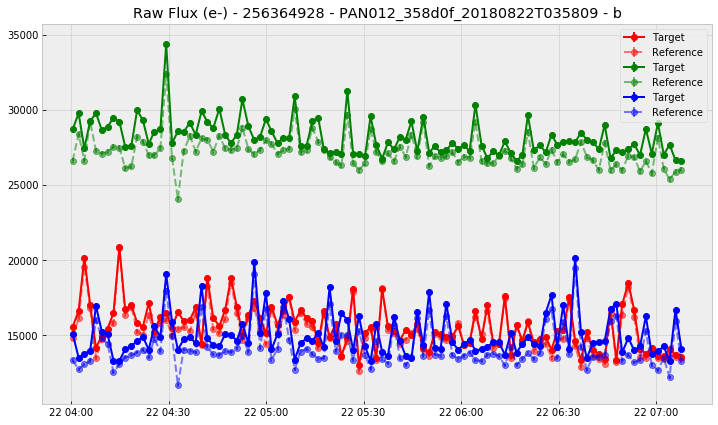

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)

for color in 'rgb':
    y = lc0.loc[lc0.color == color]
    x = y.index

    ax.errorbar(x, y.target.values, yerr=y.target_err.values, marker='o', color=color, label='Target')
    ax.errorbar(x, y.reference.values, yerr=y.reference_err.values, color=color, ls='--', alpha=0.5, marker='o', label='Reference')
    ax.set_title(f'Raw Flux (e-) - {picid} - {sequence} - {color}')
    ax.legend()

    plots_dir = os.path.join(psc_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)

    raw_flux_fn = os.path.join(psc_dir, 'plots', f'raw-flux-{picid}.png')

# fig.savefig(raw_flux_fn, transparent=False, bbox_inches='tight')
plt.close('all')

display.display(fig)

### Normalized flux

Show the normalized target and reference along with error bars (which are small enough to not be seen in offset).

In [11]:
# Normalize the flux values.
lc1 = pipeline.normalize_lightcurve(lc0)

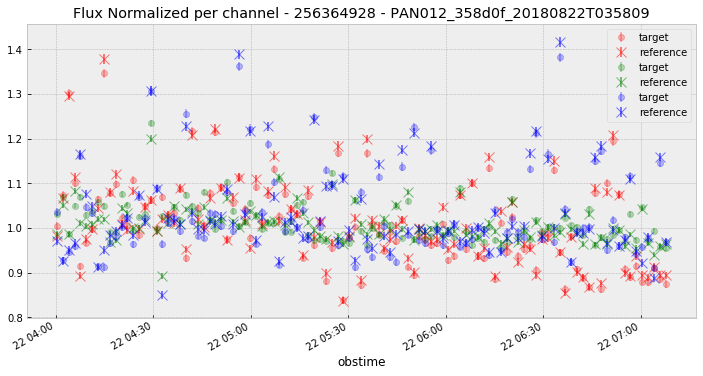

In [14]:
plt.figure(figsize=(12, 6))
i = 0
for color in 'rgb':
    color_data = lc1.loc[lc1.color == color]
    (color_data.target + i).plot(marker='o', yerr=color_data.target_err, color=color, ls='', alpha=0.25)
    (color_data.reference + i).plot(marker='x', ms=10, yerr=color_data.reference_err, color=color, ls='', alpha=0.5)
    i += .0

# plt.ylim([.9, 1.1])
plt.title(f'Flux Normalized per channel - {picid} - {sequence}')
plt.legend()

Show the normalized light curve along with the residual scatter information.

### Exoplanet info

HD 189733 b
```
a........... 8.83602
ecc......... 0.0
fp.......... None
inc......... 85.71
limb_dark... uniform
per......... 2.21857567
rp.......... 0.15468774550850156
t0.......... 0.0
t_secondary. None
u........... []
w........... 90.0
```

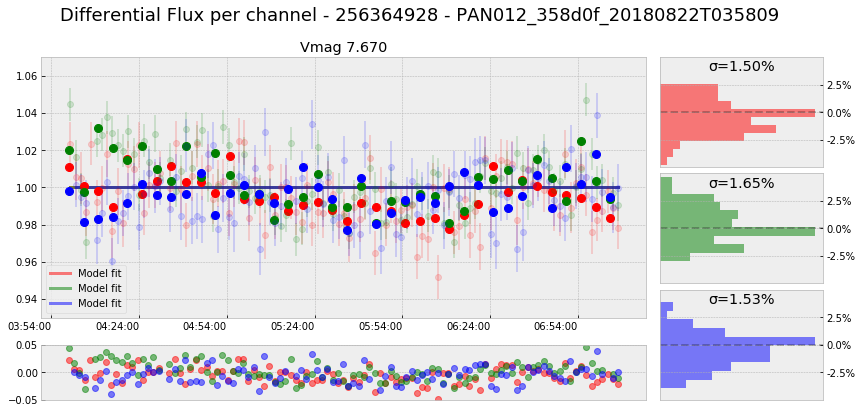

In [13]:
title = f'Differential Flux per channel - {picid} - {sequence}'

# Exoplanet model
#     lc1 = pipeline.normalize_lightcurve(lc0, method='mean', use_frames=slice(0, 20))
#     title = f'Differential Flux per channel - Ingress Mean - {picid} - {sequence}'
#     base_model_flux=get_exoplanet_transit(lc1.index.unique(), transit_times=transit_times)

# Make a plot of the light curve.
fig = plot.plot_lightcurve(lc1, 
                           title=title,
                           time_bin=5, # Minutes
                           transit_datetimes=transit_datetimes,
                           base_model_flux=base_model_flux
                          )

# Add Vmag title
try:      
    vmag = sources.query(f'picid == {picid}').vmag[0]
    fig.axes[0].set_title(f'Vmag {vmag:.03f}')
except Exception:
    pass

# Save the plot
# lc_plot_fn = os.path.join(psc_dir, 'plots', f'lightcurve-{picid}.png')
save_dir = os.path.join('/var/panoptes/temp/plots', sequence)
os.makedirs(save_dir, exist_ok=True)
lc_plot_fn = os.path.join(save_dir, f'lightcurve-{picid}.png')

fig.savefig(lc_plot_fn, transparent=False, bbox_inches='tight')

display.display(fig)